### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical

### IMPORTING / VIEWING / PREPROCESSING DATASET 

> `DATA AUGMENTATION`

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 20)

Found 4098 images belonging to 4 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 20)

Found 1023 images belonging to 4 classes.


In [5]:
'''fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')'''

"fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))\n\nfor i in tqdm(range(0,5)):\n    rand1 = np.random.randint(len(train_dataset))\n    rand2 = np.random.randint(100)\n    ax[i].imshow(train_dataset[rand1][0][rand2])\n    ax[i].axis('off')\n    a = train_dataset[rand1][1][rand2]\n    if a[0] == 1:\n        ax[i].set_title('Mild Dementia')\n    elif a[1] == 1:\n        ax[i].set_title('Moderate Dementia')\n    elif a[2] == 1:\n        ax[i].set_title('Non Demetia')\n    elif a[3] == 1:\n        ax[i].set_title('Very Mild Dementia')"

### MODEL BUILDING

In [6]:
base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

58892288/58889256 [==============================] - 0s 0us/step


In [7]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [8]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [9]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [10]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRICS = [
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),  
      tensorflow.keras.metrics.AUC(name='auc')]

model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)

In [11]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [12]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
205/205 [==============================] - ETA: 0s - loss: 1.3805 - accuracy: 0.7540 - precision: 0.5091 - recall: 0.4505 - auc: 0.7745
Epoch 00001: val_auc improved from -inf to 0.72880, saving model to ./best_weights.hdf5
205/205 [==============================] - 69s 337ms/step - loss: 1.3805 - accuracy: 0.7540 - precision: 0.5091 - recall: 0.4505 - auc: 0.7745 - val_loss: 1.1293 - val_accuracy: 0.7549 - val_precision: 0.5189 - val_recall: 0.2688 - val_auc: 0.7288
Epoch 2/100
205/205 [==============================] - ETA: 0s - loss: 1.0665 - accuracy: 0.7781 - precision: 0.5676 - recall: 0.4714 - auc: 0.8178
Epoch 00002: val_auc improved from 0.72880 to 0.76148, saving model to ./best_weights.hdf5
205/205 [==============================] - 54s 262ms/step - loss: 1.0665 - accuracy: 0.7781 - precision: 0.5676 - recall: 0.4714 - auc: 0.8178 - val_loss: 1.2198 - val_accuracy: 0.7578 - val_precision: 0.5214 - val_recall: 0.3803 - val_auc: 0.7615
Epoch 3/100
205/205 [========

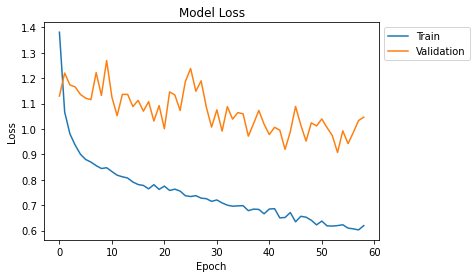

In [13]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

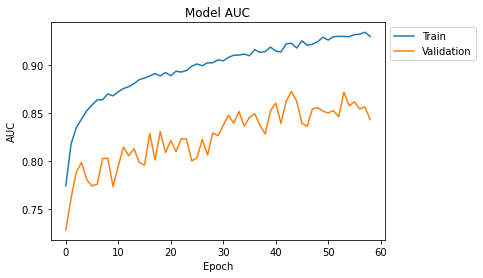

In [14]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [15]:
test_dataset  = test_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 20)

Found 1279 images belonging to 4 classes.


In [16]:
pred_labels = model.predict(test_dataset)

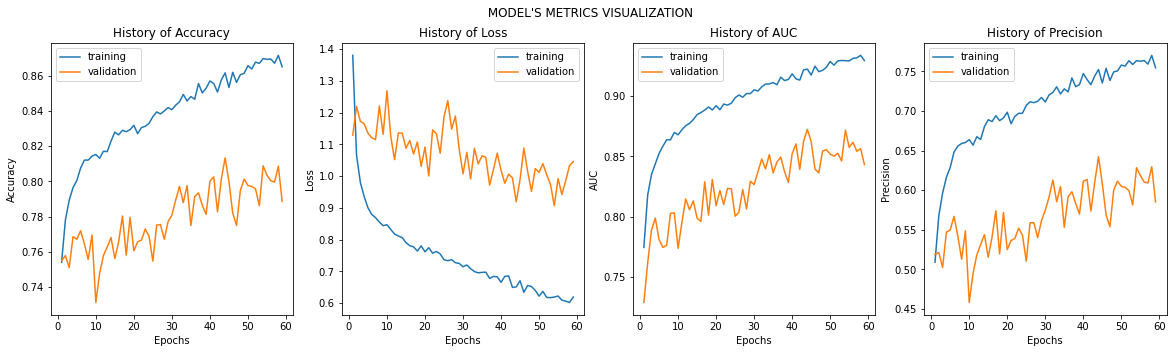

In [17]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision']
              )

In [18]:
'''CLASSES = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))'''

"CLASSES = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']\ndef roundoff(arr):\n    arr[np.argwhere(arr != arr.max())] = 0\n    arr[np.argwhere(arr == arr.max())] = 1\n    return arr\n\nfor labels in pred_labels:\n    labels = roundoff(labels)\n\nprint(classification_report(test_labels, pred_labels, target_names=CLASSES))"

In [19]:
scores = model.evaluate_generator(test_dataset)
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])

Accuracy =  0.8303362131118774
Precision =  0.6740050911903381
Recall =  0.6223612427711487
AUC =  0.8960751295089722
